In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore
from tensorflow.keras.applications import ResNet50 #type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout#type: ignore
from tensorflow.keras.models import Model #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore
import splitfolders
import os, random, shutil
from pathlib import Path
import json
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('dataset_stats.csv')

df.describe()

,image_count,avg_width,avg_height,min_width,min_height,max_width,max_height,corrupt_files
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.0
mean,119.060000,138.440000,128.540000,88.680000,70.900000,186.840000,140.0,0.0
std,29.711133,5.628499,4.343468,9.474865,10.988398,53.556135,0.0,0.0
min,74.000000,129.000000,119.000000,49.000000,40.000000,162.000000,140.0,0.0
25%,93.000000,134.000000,125.000000,82.500000,67.250000,162.000000,140.0,0.0
50%,108.000000,137.500000,129.000000,93.000000,69.000000,162.000000,140.0,0.0
75%,149.000000,143.000000,131.750000,93.000000,77.750000,162.000000,140.0,0.0
max,150.000000,151.000000,136.000000,105.000000,91.000000,300.000000,140.0,0.0


In [4]:
for name, count in zip(df['class'], df['image_count']):
    print(name,count)


adidas_forum_high 150
adidas_ultraboost 150
new_balance_550 150
new_balance_574 150
converse_one_star 150
nike_cortez 150
nike_dunk_high 150
nike_air_max_90 150
nike_air_jordan_4 150
new_balance_992 150
nike_air_max_270 149
nike_air_vapormax_flyknit 149
vans_sk8-hi 149
adidas_gazelle 149
converse_chuck_70_low 148
yeezy_boost_350_v2 148
puma_suede_classic 148
reebok_club_c_85 148
nike_air_force_1_mid 148
vans_authentic 148
adidas_stan_smith 147
salomon_xt-6 147
nike_air_force_1_low 147
yeezy_slide 145
yeezy_700_wave_runner 108
new_balance_327 108
nike_air_vapormax_plus 107
nike_air_max_1 106
nike_air_jordan_3 100
reebok_classic_leather 98
nike_air_max_97 97
nike_blazer_mid_'77 97
adidas_nmd_r1 95
new_balance_990 95
nike_air_jordan_11 93
vans_old_skool 93
converse_chuck_taylor_all-star_low 93
nike_air_max_plus_(tn) 93
adidas_superstar 93
adidas_forum_low 92
asics_gel-lyte_iii 91
vans_slip-on_checkerboard 88
nike_air_force_1_high 87
nike_air_max_95 86
nike_dunk_low 80
nike_air_jordan_1_lo

<Axes: >

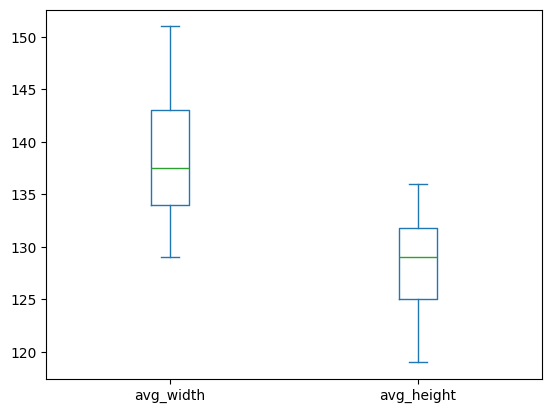

In [5]:
df[['avg_width','avg_height']].plot(kind='box')


In [11]:

src = Path("sneakers-dataset")   # each subfolder = class
dst = Path("splits")               # keep OUTSIDE src
allowed = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".jfif"}
random.seed(42)

# clean/create targets
for part in ("train","val","test"):
    (dst/part).mkdir(parents=True, exist_ok=True)

total = 0
for cls_dir in sorted([d for d in src.iterdir() if d.is_dir()]):
    files = [p for p in cls_dir.iterdir() if p.is_file() and p.suffix.lower() in allowed]
    if not files:
        print(f"[warn] no images in: {cls_dir}")
        continue

    random.shuffle(files)
    n = len(files); n_train = int(0.8*n); n_val = int(0.1*n)

    splits = {
        "train": files[:n_train],
        "val":   files[n_train:n_train+n_val],
        "test":  files[n_train+n_val:],
    }

    for part, flist in splits.items():
        out = dst/part/cls_dir.name
        out.mkdir(parents=True, exist_ok=True)
        for f in flist:
            shutil.copy2(f, out/f.name)

    total += n
    print(f"{cls_dir.name}: {n} -> train {n_train}, val {n_val}, test {n - n_train - n_val}")

print("Done. Total images:", total)



adidas_forum_high: 150 -> train 120, val 15, test 15
adidas_forum_low: 92 -> train 73, val 9, test 10
adidas_gazelle: 149 -> train 119, val 14, test 16
adidas_nmd_r1: 95 -> train 76, val 9, test 10
adidas_samba: 74 -> train 59, val 7, test 8
adidas_stan_smith: 147 -> train 117, val 14, test 16
adidas_superstar: 93 -> train 74, val 9, test 10
adidas_ultraboost: 150 -> train 120, val 15, test 15
asics_gel-lyte_iii: 91 -> train 72, val 9, test 10
converse_chuck_70_high: 75 -> train 60, val 7, test 8
converse_chuck_70_low: 148 -> train 118, val 14, test 16
converse_chuck_taylor_all-star_high: 78 -> train 62, val 7, test 9
converse_chuck_taylor_all-star_low: 93 -> train 74, val 9, test 10
converse_one_star: 150 -> train 120, val 15, test 15
new_balance_327: 108 -> train 86, val 10, test 12
new_balance_550: 150 -> train 120, val 15, test 15
new_balance_574: 150 -> train 120, val 15, test 15
new_balance_990: 95 -> train 76, val 9, test 10
new_balance_992: 150 -> train 120, val 15, test 15
nik

In [ ]:


train_gen = ImageDataGenerator(
    rescale=1./255,                     # [snippet] scale pixels to [0,1]

    rotation_range=20,                  # [snippet] rotate within ±20°
    # rotation_range=0                  # disable rotation

    width_shift_range=0.10,             # [snippet] horizontal shift up to ±10%
    height_shift_range=0.10,            # [snippet] vertical shift up to ±10%
    # width_shift_range=0.0             # disable width shift
    # height_shift_range=0.0            # disable height shift

    shear_range=0.15,                   # [snippet] projective skew
    # shear_range=0.0                   # disable shear

    zoom_range=0.20,                    # [snippet] zoom in/out up to 20%
    # zoom_range=[1.0, 1.2]             # only zoom-in
    # zoom_range=[0.8, 1.0]             # only zoom-out

    brightness_range=[0.7, 1.3],        # [snippet] random brightness
    # brightness_range=None             # disable brightness jitter

    channel_shift_range=30,             # [snippet] random RGB shift (color cast)
    # channel_shift_range=0             # disable color shift

    horizontal_flip=True,               # [snippet] left-right flip
    # horizontal_flip=False             # disable flip

    fill_mode='nearest'                 # [snippet] fill gaps after transforms
    # fill_mode='reflect'               # alternative
    # fill_mode='constant'              # with cval=0 (black)
    # cval=128                          # used if fill_mode='constant'
)


val_gen = ImageDataGenerator(rescale=1./255)

In [17]:
train = train_gen.flow_from_directory(
    "./splits/train", target_size=(224,224),
    batch_size=32, shuffle=True, class_mode="categorical", seed=42
)
val = val_gen.flow_from_directory(
    "./splits/val", target_size=(224,224),
    batch_size=32, shuffle=False, class_mode="categorical"
)


Found 4747 images belonging to 51 classes.
Found 571 images belonging to 51 classes.


In [ ]:
import matplotlib.pyplot as plt, numpy as np

x, y = next(train)              # one batch
for i in range(9):
    plt.figure()
    plt.imshow(np.clip(x[i], 0, 1))
    plt.axis("off")


In [6]:
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [19]:
base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# freeze most layers
for layer in base.layers[:-10]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step


In [20]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
out = Dense(train.num_classes, activation="softmax")(x)

model = Model(inputs=base.input, outputs=out)
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=10
)

val_loss, val_acc = model.evaluate(val)
print(f"Validation accuracy: {val_acc:.3f}")


In [10]:
# load trained model
model = tf.keras.models.load_model("best_resnet50_sneakers.h5")

# load label mapping
with open("class_indices.json") as f:
    class_indices = json.load(f)
idx_to_class = {v: k for k, v in class_indices.items()}


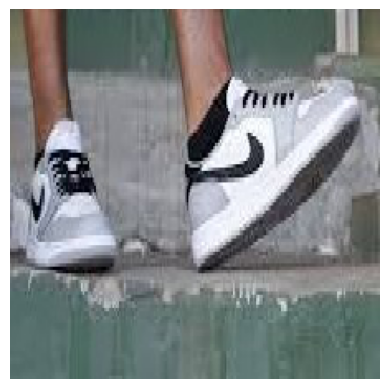

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted class: nike_air_jordan_1_low
Confidence: 0.42564818


In [32]:
img_path = "./jordan12.jpeg"
img = image.load_img(img_path, target_size=(224,224))   # same size as training
x = image.img_to_array(img)
x = x / 255.0   

plt.imshow(x)
plt.axis("off")
plt.show()                                        # same rescale
x = np.expand_dims(x, axis=0)

pred = model.predict(x)
i = np.argmax(pred[0])
print("Predicted class:", idx_to_class[i])
print("Confidence:", pred[0][i])


In [40]:
from ultralytics import YOLO

# community model with 'shoe' class (example, replace if removed)
model_det = YOLO("footwear-w1uf6/2")
results = model_det("/content/test_image.jpg", save=True, save_crop=True, project="/content", name="footwear_crops")


FileNotFoundError: 'footwear-w1uf6/2' does not exist